In [2]:
suppressMessages({
  options(stringsAsFactors = FALSE)
  library(ggsci)
  library(ggplot2)
  library(dplyr)
  library(Matrix)
  library(pheatmap)
  library(ggpubr)
  # library(scatterplot3d)
  library(plotly)
  library(RColorBrewer)
  library(scales)
  library(readr)
  library(data.table)
  library(Seurat)
})

In [ ]:
mytheme <- ggplot2::theme(
  plot.background = element_blank(),
  panel.background = element_rect(fill = "#FFFFFF"),
  legend.background = element_blank(),
  legend.box.background = element_blank(),
  panel.border = element_rect(linetype = "solid", colour = "black", fill = NA, size = 0.5),
  panel.grid.major = element_blank(), # element_line(colour = "#f0f0f0", linetype = "dashed"),
  panel.grid.minor = element_blank(),
  axis.line = element_blank()
)

dimplot_theme <- mytheme + theme(
  legend.text = element_text(size = 20), plot.title = element_blank(),
  axis.text = element_blank(), axis.ticks = element_blank(), aspect.ratio = 1
)

featureplot_theme <- mytheme + theme(
  panel.grid.major = element_blank(),
  axis.text = element_blank(), axis.ticks = element_blank(), axis.title = element_blank(), aspect.ratio = 1
) + NoLegend()

color <- c(c(pal_d3("category20")(20), "#B52D73", "#4347B5", "#4FED28", "#402727", "#48959C", "#FC6262", "#4A9EFF", "#9E969E"))
# specify colors
data_color <- c("#197EC0FF", "#ff8000")
tissue_color <- c("#2CA02CFF", "#E377C2FF")
celltype1_color <- c("#0072B5FF", "#D62728FF") # c(pal_nejm("default")(8)[c(2,1)])
celltype2_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF")
celltype3_color <- c("#9467BDFF", "#FF95A8FF", "#8AA600", "#46732EFF", "#197EC0FF", "#D62728FF", "#ff7f00", "#ffff33", "#8A9197FF")
celltype4_color <- c("#20854EFF", "#008EA0FF", "#FF6F00FF", "#C71000FF")

patient_color <- c(
  "#FED439FF", "#8A9197FF", "#8A4198FF", "#D5E4A2FF", "#197EC0FF", "#FD7446FF", "#46732EFF", "#71D0F5FF", "#E377C2FF",
  "#075149FF", "#e60000", "#91331FFF", "#1A9993FF", "#ff80aa", "#D2AF81FF", "#370335FF", "#cc99ff", "#ff8000", "#59b300"
)

# Load metadata and exp data

## merge sample info of CRC and HTCRC data

In [ ]:
meta_crc <- read.csv(file = "../../0_smk_scanseq/config/00_sample_info_2184cells.txt", header = T, check.names = F, sep = "\t") %>%
  mutate(
    data = "CRC",
    barcode3 = "None",
    barcode5 = "None",
    position_sub = position,
    position = case_when(position %in% c("T1", "T1_1", "T1_2", "T1_3") ~ "T1", TRUE ~ "T2")
  ) %>%
  select(CellName, data, patient, tissue, library, position, position_sub, barcode, barcode3, barcode5)

meta_htcrc <- read.csv(file = "../../0_smk_scanseq2HT/config/Barcode_Combinations.csv", header = T) %>%
  mutate(
    data = "HTCRC",
    patient = sapply(strsplit(library, split = "_"), function(x) {
      x[1]
    }),
    tissue = sapply(strsplit(library, split = "_"), function(x) {
      x[2]
    }),
    position = "T1",
    position_sub = position,
    tissue = case_when(tissue %in% c("PT", "PT1", "PT2") ~ "PT", TRUE ~ "NT")
  ) %>%
  select(CellName, data, patient, tissue, library, position, position_sub, barcode, barcode3, barcode5)

meta <- rbind(meta_crc, meta_htcrc)
write.table(meta, file = "01_meta_CRC_HTCRC_5400cells.txt", quote = F, sep = "\t")

In [11]:
# meta <- read.table(file = '01_meta_CRC_HTCRC_5400cells.txt', header=T, sep='\t')

In [12]:
table(meta$tissue)


  NT   PT 
1857 3543 

In [221]:
table(meta$data)


  CRC HTCRC 
 2184  3216 

In [189]:
clas <- read.table(file = "../../0_smk_CRC_HTCRC/results/08_corrected_new_ref/00_corrected_classification.txt", header = T, sep = "\t")
dim(clas)
head(clas, 1)

[1] 29429    58

,isoform,GeneName,TranID,TranName,GeneID,chrom,strand,length,exons,structural_category,⋯,polyA_dist,polyA_motif_found,ORF_seq,ratio_TSS,POS_MLprob,NEG_MLprob,ML_classifier,intra_priming,filter_result,exp
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<int>,<lgl>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<dbl>
1,CRC.100010.3,MOSMO,ENST00000562695,MOSMO-204,ENSG00000185716,16,+,695,2,full-splice_match,⋯,-15,TRUE,MDKLTIISGCLFLAADIFAIASIANPDWINTGESAGALTVGLVRQCQTIHGRDRTCIPPRLPPEWVTTLFFIIMGIISLTVTCGLLVASHWRREATKYARWIAFTGSK,NA,0.836,0.164,Positive,FALSE,Isoform,0.01406395


In [190]:
# tran counts
tx_cts <- fread(file = "../../0_smk_CRC_HTCRC/results/08_quant_corrected_new_ref_merge/tran_counts.txt", sep = "\t") %>% as.data.frame()
dim(tx_cts)
head(tx_cts, 2)

[1] 29429  5401

,TranID,CRC01_L1_Barcode01,CRC01_L1_Barcode02,CRC01_L1_Barcode03,CRC01_L1_Barcode04,CRC01_L1_Barcode05,CRC01_L1_Barcode06,CRC01_L1_Barcode07,CRC01_L1_Barcode08,CRC01_L1_Barcode09,⋯,HTCRC05_PT2_Bc96_Bc39,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc41,HTCRC05_PT2_Bc96_Bc42,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47,HTCRC05_PT2_Bc96_Bc48
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CRC.100027.1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,CRC.10019.5,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## calculating gene count matrix

In [191]:
all(sort(clas$TranID) == sort(tx_cts$TranID))
tx_cts <- merge(clas[, c("TranID", "TranName", "GeneName")], tx_cts, by = "TranID")
tx_cts <- tx_cts[order(tx_cts$GeneName, tx_cts$TranName), ]
dim(tx_cts)
head(tx_cts, 1)

[1] TRUE

[1] 29429  5403

,TranID,TranName,GeneName,CRC01_L1_Barcode01,CRC01_L1_Barcode02,CRC01_L1_Barcode03,CRC01_L1_Barcode04,CRC01_L1_Barcode05,CRC01_L1_Barcode06,CRC01_L1_Barcode07,⋯,HTCRC05_PT2_Bc96_Bc39,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc41,HTCRC05_PT2_Bc96_Bc42,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47,HTCRC05_PT2_Bc96_Bc48
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10387,ENST00000365328,7SK.1-201,7SK,0,0,0,0.990937,1.984894,0,0,⋯,0,0,0.652568,0,1,0,9.963746,1,0,0


In [192]:
gene_cts <- aggregate(. ~ GeneName, tx_cts[, c("GeneName", meta$CellName)], sum)
tx_cts <- tx_cts[, c("TranName", meta$CellName)]

In [193]:
fwrite(gene_cts, file = "00_gene_counts_5400cells.txt", quote = FALSE, row.names = FALSE, sep = "\t")
fwrite(tx_cts, file = "00_tx_counts_5400cells.txt", quote = FALSE, row.names = FALSE, sep = "\t")

In [238]:
dim(gene_cts)

[1] 12827  5400

# quality control

In [194]:
tx_cts <- fread(file = "00_tx_counts_5400cells.txt", quote = F, sep = "\t") %>%
  as.data.frame() %>%
  `rownames<-`(.[, 1]) %>%
  .[, -1]
dim(tx_cts)
head(tx_cts, 2)

[1] 29429  5400

,CRC01_L1_Barcode01,CRC01_L1_Barcode02,CRC01_L1_Barcode03,CRC01_L1_Barcode04,CRC01_L1_Barcode05,CRC01_L1_Barcode06,CRC01_L1_Barcode07,CRC01_L1_Barcode08,CRC01_L1_Barcode09,CRC01_L1_Barcode10,⋯,HTCRC05_PT2_Bc96_Bc39,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc41,HTCRC05_PT2_Bc96_Bc42,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47,HTCRC05_PT2_Bc96_Bc48
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7SK.1-201,0,0,0,0.990937,1.984894,0,0,0,0,0,⋯,0,0,0.652568,0,1,0,9.963746,1,0,0
A1CF-202,0,0,0,0.000000,0.000000,0,0,0,0,0,⋯,0,0,0.000000,0,0,0,0.000000,0,0,0


In [195]:
gene_cts <- fread(file = "00_gene_counts_5400cells.txt", quote = F, sep = "\t") %>%
  as.data.frame() %>%
  `rownames<-`(.[, 1]) %>%
  .[, -1]
dim(gene_cts)
head(gene_cts, 2)

[1] 12827  5400

,CRC01_L1_Barcode01,CRC01_L1_Barcode02,CRC01_L1_Barcode03,CRC01_L1_Barcode04,CRC01_L1_Barcode05,CRC01_L1_Barcode06,CRC01_L1_Barcode07,CRC01_L1_Barcode08,CRC01_L1_Barcode09,CRC01_L1_Barcode10,⋯,HTCRC05_PT2_Bc96_Bc39,HTCRC05_PT2_Bc96_Bc40,HTCRC05_PT2_Bc96_Bc41,HTCRC05_PT2_Bc96_Bc42,HTCRC05_PT2_Bc96_Bc43,HTCRC05_PT2_Bc96_Bc44,HTCRC05_PT2_Bc96_Bc45,HTCRC05_PT2_Bc96_Bc46,HTCRC05_PT2_Bc96_Bc47,HTCRC05_PT2_Bc96_Bc48
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7SK,0.000000,0,0.000000,0.990937,1.984894,0,0,0,0,0,⋯,0,0,0.652568,0,1,0,9.963746,1,0,0
A1CF,8.337652,0,0.287963,0.000000,0.000000,0,0,0,0,0,⋯,0,0,0.000000,0,0,0,0.000000,0,0,0


## claculating gene number and transcript number

In [196]:
meta$gene_number <- colSums(gene_cts > 0)
meta$transcript_number <- colSums(tx_cts > 0)
summary(meta$gene_number)
summary(meta$transcript_number)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   49.0   713.8  1488.0  2063.2  2905.2  9283.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   54.0   906.8  1923.5  2878.6  3902.0 15730.0 

In [197]:
# sample summary
summary_stat_crc <- read.csv(file = "../../0_smk_scanseq/results/summary_stat_merge/summary_stat_merge.csv", header = T)
summary_stat_htcrc <- read.csv(file = "../../0_smk_scanseq2HT/results/summary_stat_merge/summary_stat_merge.csv", header = T)
summary_stat <- rbind(summary_stat_crc, summary_stat_htcrc) %>% filter(CellName %in% meta$CellName)
dim(summary_stat)
head(summary_stat, 1)

[1] 5400    7

,CellName,demultiplexing_reads,qc_reads,full_length_cnda_reads,full_length_cdna_len_mean,full_length_cdna_len_median,genome_mapping_primary_reads
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,CRC01_L1_Barcode01,582862,582862,482916,1826,2259,465679


In [198]:
df_summary <- merge(meta, summary_stat, by = "CellName", all.x = T)
rownames(df_summary) <- df_summary$CellName
dim(df_summary)
head(df_summary, 1)

[1] 5400   18

,CellName,data,patient,tissue,library,position,position_sub,barcode,barcode3,barcode5,gene_number,transcript_number,demultiplexing_reads,qc_reads,full_length_cnda_reads,full_length_cdna_len_mean,full_length_cdna_len_median,genome_mapping_primary_reads
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
CRC01_L1_Barcode01,CRC01_L1_Barcode01,CRC,CRC01,NT,CRC01_L1,T1,T1,Barcode01,None,None,4742,6984,582862,582862,482916,1826,2259,465679


In [199]:
# ensure sample name between metadata and gene count matrix
all(rownames(df_summary) == colnames(gene_cts))
all(sort(rownames(df_summary)) == sort(colnames(gene_cts)))
all(sort(rownames(df_summary)) == sort(colnames(tx_cts)))

[1] TRUE

[1] TRUE

[1] TRUE

In [200]:
# ordering
gene_cts <- gene_cts[, rownames(df_summary)]
tx_cts <- tx_cts[, rownames(df_summary)]
all(rownames(df_summary) == colnames(gene_cts))
all(rownames(df_summary) == colnames(tx_cts))

[1] TRUE

[1] TRUE

In [201]:
# genes in mitochondria
mt_genes <- read.table(file = "../../0_smk_scanseq/resources/GRCh38_ensembl_108/gtf/MT_gene.txt", header = F)
mt_genes <- intersect(mt_genes$V1, rownames(gene_cts))
length(mt_genes)
# calculate MT ratio
df_summary$MT_ratio <- as.numeric(colSums(gene_cts[mt_genes, ]) / colSums(gene_cts))

[1] 15

In [202]:
write.csv(df_summary, file = "00_summary_5400cells.csv", quote = FALSE)

## filtering standards: gene number > 500, MT_ratio < 0.6

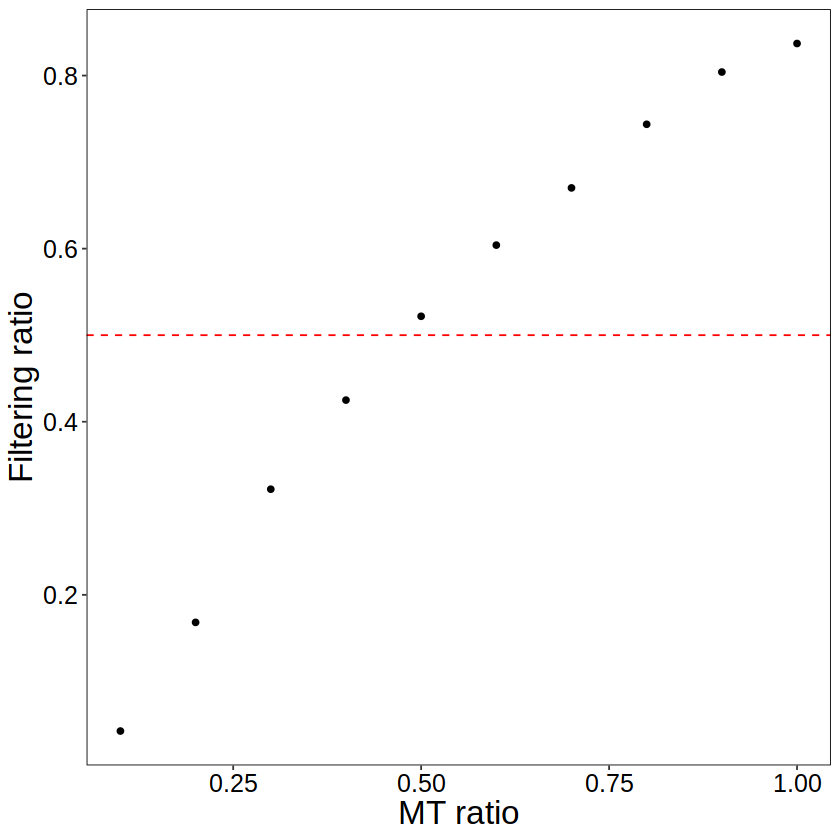

In [203]:
# For setting a standard of filtering
ggplot(data = NULL, aes(
  x = seq(from = 0.1, to = 1, by = 0.1), y =
    c(
      dim(df_summary[df_summary$MT_ratio < 0.1 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1],
      dim(df_summary[df_summary$MT_ratio < 0.2 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1],
      dim(df_summary[df_summary$MT_ratio < 0.3 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1],
      dim(df_summary[df_summary$MT_ratio < 0.4 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1],
      dim(df_summary[df_summary$MT_ratio < 0.5 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1],
      dim(df_summary[df_summary$MT_ratio < 0.6 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1],
      dim(df_summary[df_summary$MT_ratio < 0.7 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1],
      dim(df_summary[df_summary$MT_ratio < 0.8 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1],
      dim(df_summary[df_summary$MT_ratio < 0.9 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1],
      dim(df_summary[df_summary$MT_ratio < 1 & df_summary$gene_number > 500, ])[1] / dim(df_summary)[1]
    )
)) +
  geom_point() +
  labs(x = "MT ratio", y = "Filtering ratio") +
  geom_hline(aes(yintercept = 0.5), color = "red", linetype = "dashed") +
  mytheme

In [205]:
df_summary_qc <- df_summary[which(df_summary$gene_number > 500 & df_summary$MT_ratio < 0.6), ]
table(df_summary_qc$tissue)
dim(df_summary_qc)
dim(df_summary_qc)[1] / dim(df_summary)[1]
# table(df_summary_qc$library)/table(df_summary$library)


  NT   PT 
 692 2570 

[1] 3262   19

[1] 0.6040741

In [206]:
genenumbersgt0 <- 500
write.csv(
  df_summary_qc,
  file = sprintf(
    "00_summary_qc_%d_genenumbersgt0_%d_%d.csv",
    genenumbersgt0, dim(df_summary)[1], dim(df_summary_qc)[1]
  ), quote = F, row.names = F
)

In [207]:
gene_cts_qc <- gene_cts[, df_summary_qc$CellName]
dim(gene_cts_qc)
write.csv(
  gene_cts_qc,
  file = sprintf(
    "00_gene_counts_qc_%d_genenumbersgt0_%d_%d.csv",
    genenumbersgt0, dim(df_summary)[1], dim(df_summary_qc)[1]
  ), quote = FALSE
)
gene_tpm_qc <- as.data.frame(t(t(gene_cts_qc) * 1000000 / colSums(gene_cts_qc)))
write.csv(
  gene_tpm_qc,
  file = sprintf(
    "00_gene_tpm_qc_%d_genenumbersgt0_%d_%d.csv",
    genenumbersgt0, dim(df_summary)[1], dim(df_summary_qc)[1]
  ), quote = FALSE
)

[1] 12827  3262

In [208]:
tx_cts_qc <- tx_cts[, df_summary_qc$CellName]
dim(tx_cts_qc)
write.csv(
  tx_cts_qc,
  file = sprintf(
    "00_tx_counts_qc_%d_genenumbersgt0_%d_%d.csv",
    genenumbersgt0, dim(df_summary)[1], dim(df_summary_qc)[1]
  ), quote = F
)

tx_tpm_qc <- as.data.frame(t(t(tx_cts_qc) * 1000000 / colSums(tx_cts_qc)))
dim(tx_tpm_qc)
write.csv(
  tx_tpm_qc,
  file = sprintf(
    "00_tx_tpm_qc_%d_genenumbersgt0_%d_%d.csv",
    genenumbersgt0, dim(df_summary)[1], dim(df_summary_qc)[1]
  ), quote = FALSE
)

[1] 29429  3262

[1] 29429  3262

# generate proportion matrix of isoforms

In [5]:
tx_tpm_qc <- read.csv(file = "00_tx_tpm_qc_500_genenumbersgt0_5400_3262.csv", header = T, row.names = 1)

In [18]:
clas <- read.table(file = "../../0_smk_CRC_HTCRC/results/08_corrected_new_ref/00_corrected_classification.txt", header = T, sep = "\t")
isoform_gene_map <- clas[, c("TranName", "GeneName")]

In [35]:
# tx_tpm_qc is the isoform expression matrix, and isoform_gene_map is the correspondence between isoform and gene
library(dplyr)
library(tidyr)

# Merge tx_tpm_qc and isoform_gene_map
tx_tpm_long <- tx_tpm_qc %>%
  tibble::rownames_to_column(var = "TranName") %>%
  pivot_longer(cols = -TranName, names_to = "CellName", values_to = "TPM") %>%
  left_join(isoform_gene_map, by = "TranName")

In [36]:
# Calculate the total expression of all isoforms of each gene in each cell
gene_total_tpm <- tx_tpm_long %>%
  group_by(CellName, GeneName) %>%
  summarise(total_tpm = sum(TPM, na.rm = TRUE), .groups = "drop")

In [37]:
# Compute isoform proportion within each gene per cell
tx_tpm_long <- tx_tpm_long %>%
  left_join(gene_total_tpm, by = c("CellName", "GeneName")) %>%
  mutate(proportion = ifelse(total_tpm == 0, NA, TPM / total_tpm)) %>%
  select(CellName, GeneName, TranName, proportion)

In [39]:
setDT(tx_tpm_long)

# Use dcast to reshape data: TranName as rows, CellName as columns, proportion as values
tx_tpm_proportion <- dcast(tx_tpm_long, TranName ~ CellName, value.var = "proportion", fill = NA)

In [46]:
write.csv(
  tx_tpm_proportion,
  file = "00_tx_proportion_qc_500_genenumbersgt0_5400_3262.csv",
  quote = FALSE, row.names = F
)

# loading qc files and plotting

In [239]:
df_summary_qc <- read.csv(file = "00_summary_qc_500_genenumbersgt0_5400_3262.csv", header = T)
dim(df_summary_qc)
head(df_summary_qc, 1)

[1] 3262   19

,CellName,data,patient,tissue,library,position,position_sub,barcode,barcode3,barcode5,gene_number,transcript_number,demultiplexing_reads,qc_reads,full_length_cnda_reads,full_length_cdna_len_mean,full_length_cdna_len_median,genome_mapping_primary_reads,MT_ratio
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,CRC01_L1_Barcode01,CRC,CRC01,NT,CRC01_L1,T1,T1,Barcode01,None,None,4742,6984,582862,582862,482916,1826,2259,465679,0.136058


In [232]:
# Density plot
for (item in c(
  "demultiplexing_reads", "qc_reads", "full_length_cnda_reads", "full_length_cdna_len_mean",
  "full_length_cdna_len_median", "genome_mapping_primary_reads", "transcript_number", "gene_number"
)) {
  ggplot(df_summary_qc, aes_string(x = item)) +
    geom_density(fill = "#4292c6", alpha = 0.4, color = "#4292c6", size = 0.8) +
    scale_x_continuous(name = item) + # , limits = c(0, max(filter_summary$Gene_Number) + 1000)
    labs(title = paste0(
      "Mean:", round(mean(df_summary_qc[, item]), 0), "   ",
      "Median:", round(median(df_summary_qc[, item]), 0)
    )) +
    scale_y_continuous(labels = function(x) format(x, scientific = TRUE)) +
    mytheme
  ggsave(sprintf("%s_density_plot.pdf", item), width = 7, height = 5.5)
}

In [251]:
# Boxplot
for (item in c(
  "demultiplexing_reads", "qc_reads", "full_length_cnda_reads", "full_length_cdna_len_mean",
  "full_length_cdna_len_median", "genome_mapping_primary_reads", "transcript_number", "gene_number"
)) {
  for (mygroup in c("data", "patient", "tissue")) {
    ggplot(df_summary_qc, aes_string(x = mygroup, y = item, fill = mygroup)) +
      stat_boxplot(geom = "errorbar", linetype = 1, width = 0.2, position = position_dodge(width = 0.8)) +
      geom_boxplot(width = 0.6, size = 0.3, position = position_dodge(width = 0.8), outlier.shape = NA) +
      # scale_color_manual(values = ) +
      scale_fill_manual(values = alpha(c(data_color, color), 1)) +
      scale_x_discrete(name = mygroup) +
      scale_y_continuous(name = item) +
      theme(axis.text.x = element_text(vjust = 0.5, hjust = 0.5, angle = 45)) +
      mytheme
    ggsave(sprintf("%s_%s_boxplot_plot.pdf", item, mygroup), width = 2 + 1 * dim(table(df_summary_qc[, mygroup])), height = 4)
  }
}

# MT_ratio and gene number (response to reviewer)

In [8]:
qc_summary <- read.csv(file = "00_summary_qc_500_genenumbersgt0_2184_1395.csv", header = T)
rownames(qc_summary) <- qc_summary$CellName
dim(qc_summary)

[1] 1395   22

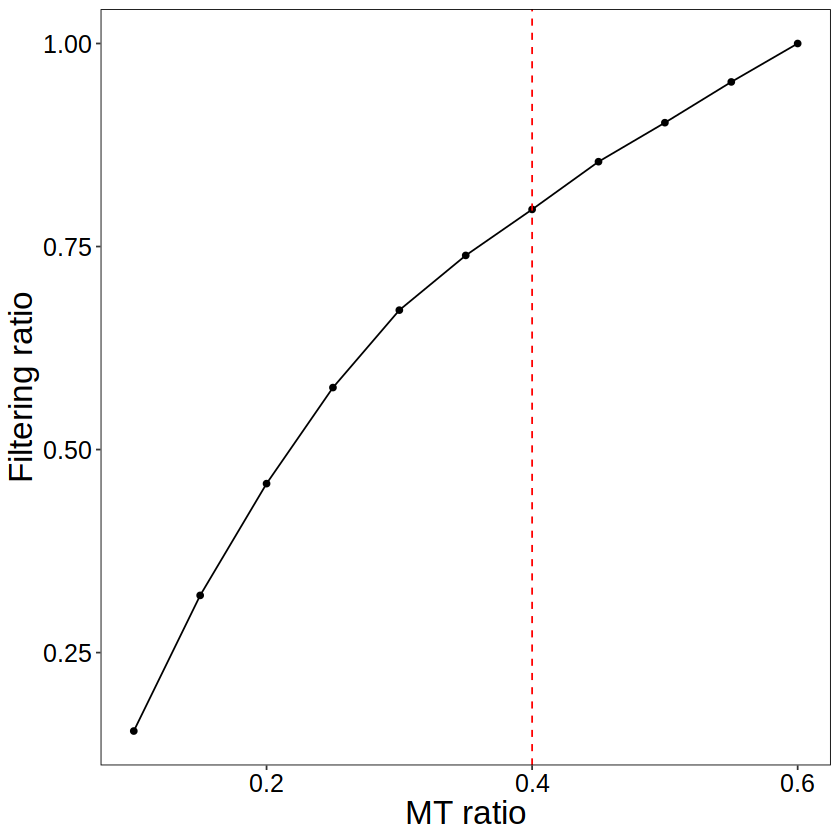

In [69]:
# Calculate the proportions for different MT ratio thresholds
mt_thresholds <- seq(0.1, 0.6, by = 0.05)
proportions <- sapply(mt_thresholds, function(threshold) {
  dim(qc_summary[qc_summary$MT_ratio < threshold & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1]
})

# Create a dataframe for plotting
plot_data <- data.frame(MT_ratio = mt_thresholds, Filtering_ratio = proportions)

ggplot(data = plot_data, aes(x = MT_ratio, y = Filtering_ratio)) +
  geom_point() +
  geom_line() + # Adding a polynomial fit line
  geom_vline(aes(xintercept = 0.4), color = "red", linetype = "dashed") +
  labs(x = "MT ratio", y = "Filtering ratio") +
  mytheme

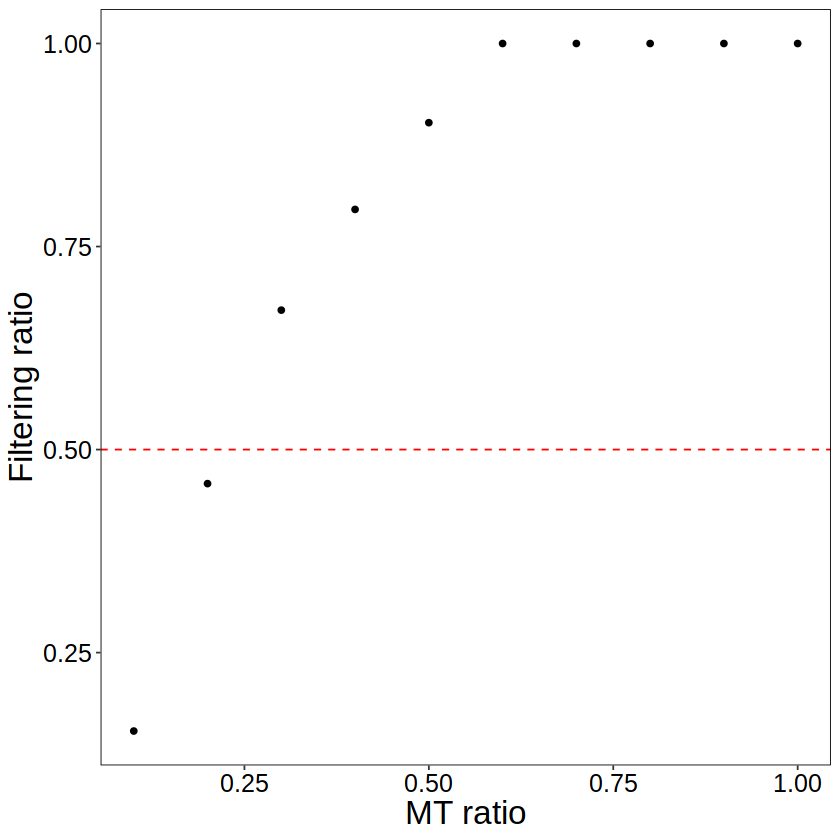

In [59]:
ggplot(data = NULL, aes(x = seq(from = 0.1, to = 1, by = 0.1), y = c(
  dim(qc_summary[qc_summary$MT_ratio < 0.1 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1],
  dim(qc_summary[qc_summary$MT_ratio < 0.2 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1],
  dim(qc_summary[qc_summary$MT_ratio < 0.3 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1],
  dim(qc_summary[qc_summary$MT_ratio < 0.4 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1],
  dim(qc_summary[qc_summary$MT_ratio < 0.5 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1],
  dim(qc_summary[qc_summary$MT_ratio < 0.6 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1],
  dim(qc_summary[qc_summary$MT_ratio < 0.7 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1],
  dim(qc_summary[qc_summary$MT_ratio < 0.8 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1],
  dim(qc_summary[qc_summary$MT_ratio < 0.9 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1],
  dim(qc_summary[qc_summary$MT_ratio < 1 & qc_summary$gene_number > 500, ])[1] / dim(qc_summary)[1]
))) +
  geom_point() +
  labs(x = "MT ratio", y = "Filtering ratio") +
  geom_hline(aes(yintercept = 0.5), color = "red", linetype = "dashed") +
  mytheme

In [36]:
dim(qc_summary[which(qc_summary$gene_number >= 1000), ])

[1] 1302   22

In [37]:
1302 / 1395

[1] 0.9333333

In [57]:
dim(qc_summary[which(qc_summary$MT_ratio < 0.4 & qc_summary$gene_number >= 1000), ])
dim(qc_summary[which(qc_summary$MT_ratio < 0.3 & qc_summary$gene_number >= 1000), ])

[1] 1063   22

[1] 905  22

In [58]:
1063 / 1395
905 / 1395

[1] 0.7620072

[1] 0.6487455

In [35]:
summary(qc_summary$gene_number)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    501    2178    4087    3844    5341    8797 

In [32]:
summary(qc_summary$MT_ratio)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.003725 0.129848 0.215712 0.251864 0.358066 0.599726 

# Cell count distribution in tumor (PT) and normal (NT) tissues across CRC patients

In [13]:
qc_summary <- read.csv(file = "00_summary_qc_500_genenumbersgt0_2184_1395.csv", header = T)
rownames(qc_summary) <- qc_summary$CellName
dim(qc_summary)

[1] 1395   22

In [14]:
df_1 <- as.data.frame(table(qc_summary$patient, qc_summary$tissue))
df_2 <- df_1 %>%
  group_by(Var1, Var2) %>%
  summarise(Freq = sum(Freq))

`summarise()` has grouped output by 'Var1'. You can override using the `.groups` argument.


In [15]:
df_2$Var1 <- factor(df_2$Var1, levels = rev(c("CRC01", "CRC02", "CRC03", "CRC04", "CRC05", "CRC07", "CRC08", "CRC09", "CRC10")))
df_2$Var2 <- factor(df_2$Var2, levels = c("PT", "NT"))
df_2 <- df_2[order(df_2$Var1, df_2$Var2), ]

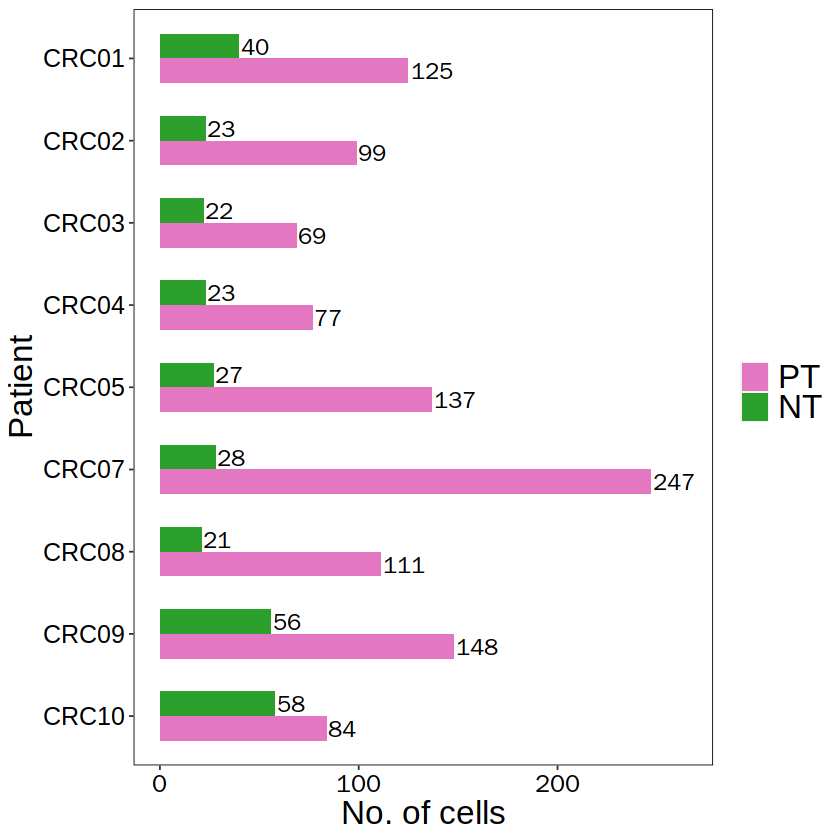

In [16]:
ggplot(data = df_2, aes(x = Var1, y = Freq, fill = Var2)) +
  geom_bar(position = position_dodge(width = 0.6), stat = "identity", width = 0.6) +
  scale_fill_manual(values = rev(tissue_color)) +
  geom_text(aes(label = Freq), position = position_dodge(width = 0.6), vjust = 0.5, hjust = -0.05, size = 5) +
  labs(x = "Patient", y = "No. of cells") +
  mytheme +
  ylim(0, 265) +
  coord_flip()
ggsave("1_qc_cell_numbers.pdf", width = 5.5, height = 10)

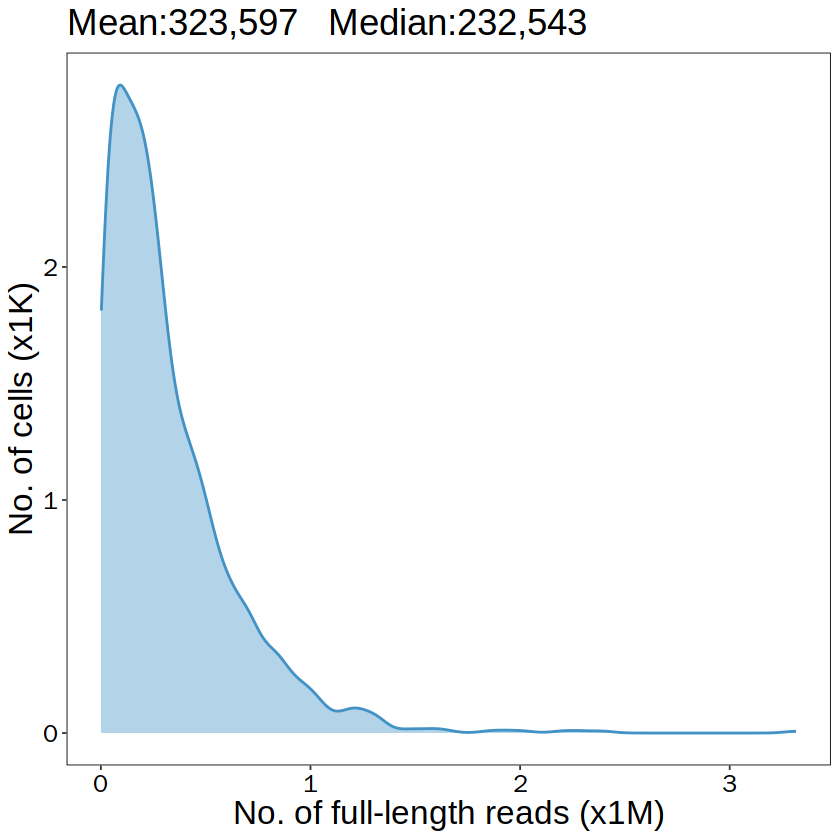

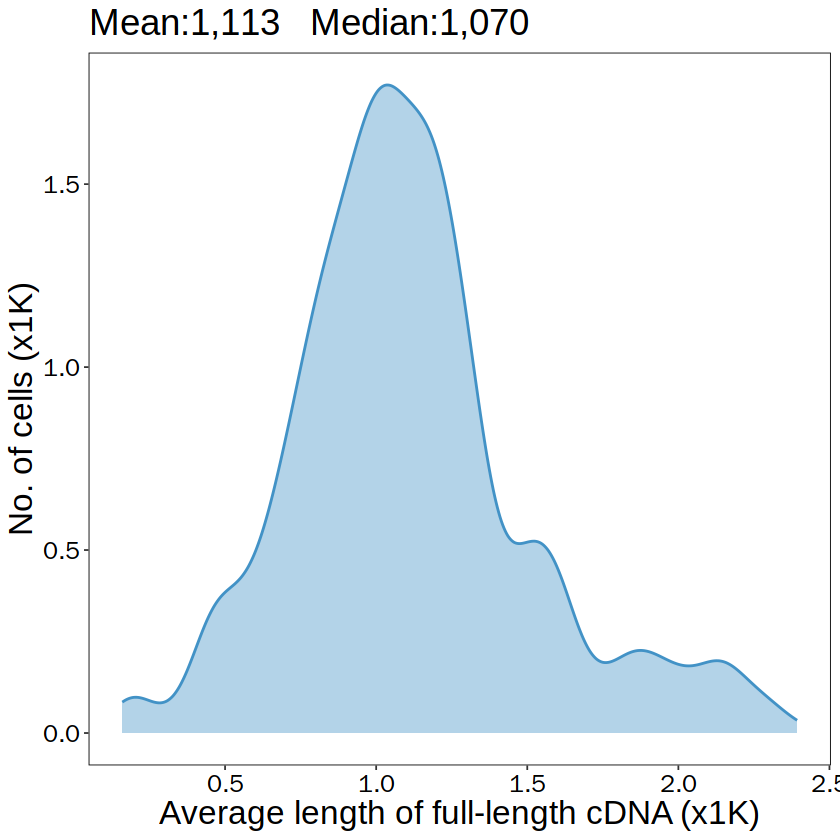

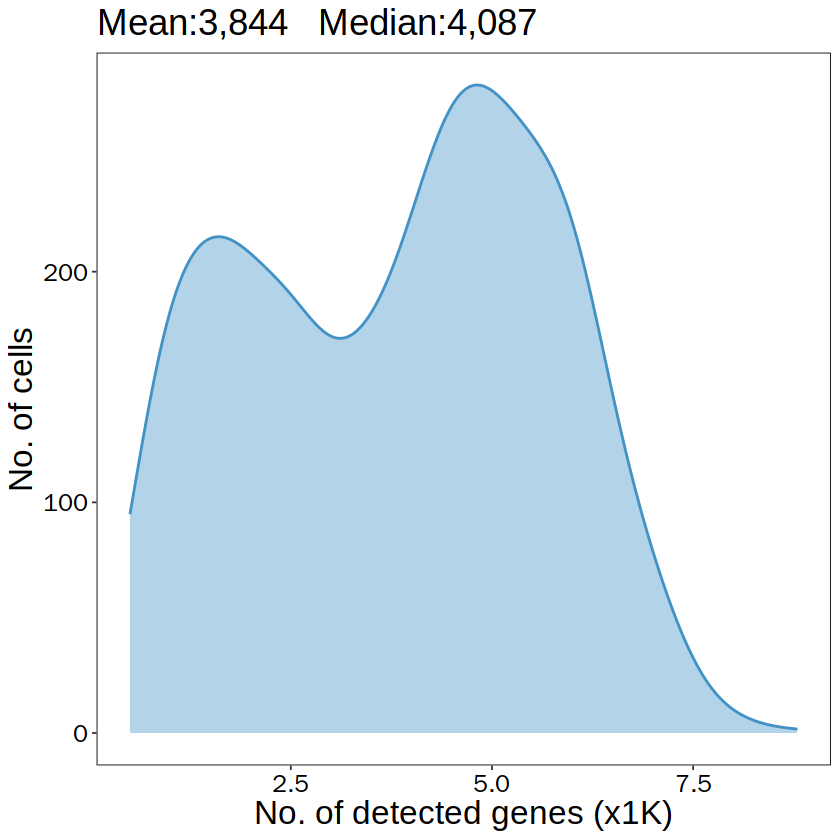

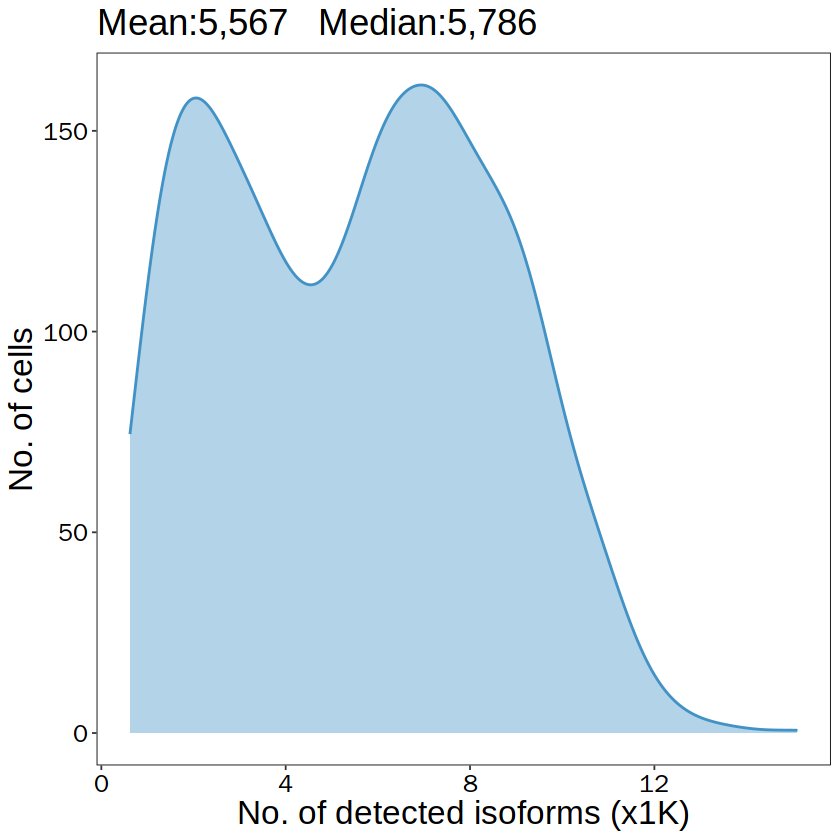

In [22]:
item <- "full_length_cnda_reads"
ggplot(qc_summary, aes(x = full_length_cnda_reads / 1000000, y = ..count.. / 1000)) +
  geom_density(fill = "#4292c6", alpha = 0.4, color = "#4292c6", size = 0.8) +
  labs(x = "No. of full-length reads (x1M)", y = "No. of cells (x1K)", title = paste0(
    "Mean:", comma(round(mean(qc_summary[, item]), 0)), "   Median:", comma(round(median(qc_summary[, item]), 0))
  )) +
  mytheme
ggsave("1_qc_full_length_cnda_reads.pdf", width = 5.2, height = 4)

item <- "full_length_cdna_len_mean"
ggplot(qc_summary, aes(x = full_length_cdna_len_mean / 1000, y = ..count.. / 1000)) +
  geom_density(fill = "#4292c6", alpha = 0.4, color = "#4292c6", size = 0.8) +
  labs(x = "Average length of full-length cDNA (x1K)", y = "No. of cells (x1K)", title = paste0(
    "Mean:", comma(round(mean(qc_summary[, item]), 0)), "   Median:", comma(round(median(qc_summary[, item]), 0))
  )) +
  mytheme
ggsave("1_qc_full_length_cdna_len_mean.pdf", width = 5.2, height = 4)

item <- "gene_number"
ggplot(qc_summary, aes(x = gene_number / 1000, y = ..count..)) +
  geom_density(fill = "#4292c6", alpha = 0.4, color = "#4292c6", size = 0.8) +
  labs(x = "No. of detected genes (x1K)", y = "No. of cells", title = paste0(
    "Mean:", comma(round(mean(qc_summary[, item]), 0)), "   Median:", comma(round(median(qc_summary[, item]), 0))
  )) +
  mytheme
ggsave("1_qc_gene_number.pdf", width = 5.2, height = 4)

item <- "transcript_number"
ggplot(qc_summary, aes(x = transcript_number / 1000, y = ..count..)) +
  geom_density(fill = "#4292c6", alpha = 0.4, color = "#4292c6", size = 0.8) +
  labs(x = "No. of detected isoforms (x1K)", y = "No. of cells", title = paste0(
    "Mean:", comma(round(mean(qc_summary[, item]), 0)), "   Median:", comma(round(median(qc_summary[, item]), 0))
  )) +
  mytheme
ggsave("1_qc_isoform_number.pdf", width = 5.2, height = 4)